In [258]:
from qutip import create, destroy, qeye, basis, ket, mesolve, sigmam, sigmap, tensor, fock_dm, Qobj,fock, sigmax, sigmaz, QobjEvo, bell_state
from qutip.solver import Options
from qutip.measurement import measurement_statistics, measure
from scipy.linalg import expm
from scipy.constants import hbar, proton_mass
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set()
sns.set_palette(sns.color_palette('bright'))
#Useful constants 
rabi_0=2e5*np.pi #Hz
omega=2e6 #Hz
ldp=.1/np.sqrt(2)
epsilon=2*ldp*rabi_0

n=10 #modes of motion
#Relevant Basis States 
g=basis(2,0)
e=basis(2,1)
gg=tensor(g, g, fock(n))   
ge=tensor(g, e, fock(n))
eg=tensor(e, g, fock(n))
ee=tensor(e,e, fock(n))

#Useful ops
sm=tensor(sigmam(),qeye(2))+tensor(qeye(2),sigmam())
sp=tensor(sigmap(),qeye(2))+tensor(qeye(2),sigmap())

$$H_{BSB}= \frac{i \eta}{2} (\Omega_b e^{i \delta_b t}S_{-}a- \Omega^{*}_b e^{-i \delta_b t}S_{+}a^{\dagger})$$
$$H_{RSB}= \frac{i \eta}{2} (\Omega_r e^{i \delta_r t}S_{-}a^{\dagger} - \Omega^{*}_r e^{-i \delta_r t}S_{+}a)$$

In [259]:

def H_MS(rabi_blue, rabi_red, blue_det, red_det):
    #Blue SB Hamiltonian terms
    H_BSB_i=(1j*ldp*rabi_blue/2)*tensor(sm,destroy(n))
    def H_BSB_TD_i(t, args):
        return np.exp(1j*(blue_det)*t)                 

    H_BSB_ii=(-1j*ldp*rabi_blue/2)*tensor(sp,create(n))
    def H_BSB_TD_ii(t, args):
        return np.exp(-1j*(blue_det)*t)

    #Red SB Hamiltonian terms
    H_RSB_i=(1j*ldp*rabi_red/2)*tensor(sm,create(n))
    def H_RSB_TD_i(t, args):
        return np.exp(1j*(red_det)*t)                 

    H_RSB_ii=(-1j*ldp*rabi_red/2)*tensor(sp,destroy(n))
    def H_RSB_TD_ii(t, args):
        return np.exp(-1j*(red_det)*t)

    #  Blue H---------------------------------------| Red H----------------------------------------|
    H=[[H_BSB_i, H_BSB_TD_i], [H_BSB_ii, H_BSB_TD_ii],[H_RSB_i, H_RSB_TD_i], [H_RSB_ii, H_RSB_TD_ii]]
    return H

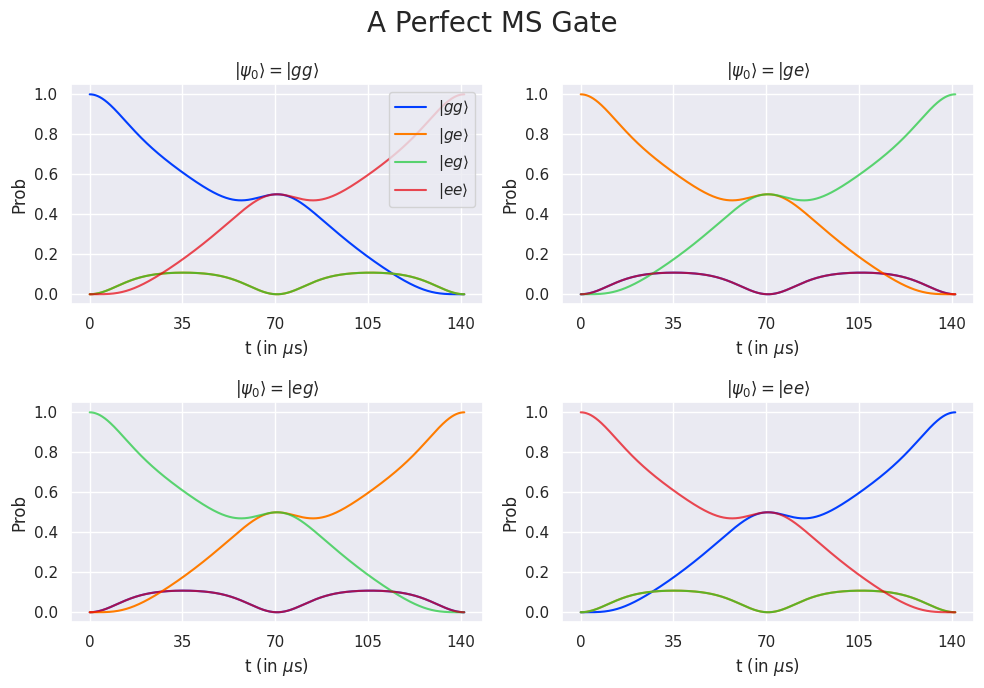

In [260]:
gate_time=4*np.pi/epsilon
tlist=np.linspace(0, gate_time, 1000)

z_basis=[tensor(g,g,qeye(n))*tensor(g.dag(),g.dag(), qeye(n)), tensor(g,e,qeye(n))*tensor(g.dag(),e.dag(), qeye(n)), 
        tensor(e,g,qeye(n))*tensor(e.dag(),g.dag(), qeye(n)), tensor(e,e,qeye(n))*tensor(e.dag(),e.dag(), qeye(n))]
H=H_MS(rabi_0, rabi_0, epsilon, -epsilon)

def plot_evol(H, rho0, title, labels=False, expect=z_basis):
    evol=mesolve(H, rho0, tlist, e_ops=expect)
    plt.plot(tlist, evol.expect[0], label=r'$|gg\rangle$')
    plt.plot(tlist, evol.expect[1], label=r'$|ge\rangle$')
    plt.plot(tlist, evol.expect[2], label=r'$|eg\rangle$', alpha=.7)
    plt.plot(tlist, evol.expect[3], label=r'$|ee\rangle$', alpha=.7)
    #plt.plot(tlist, evol.expect[4], label=r'$|EPR\rangle$', ls=':')
    plt.xlabel(r't (in $\mu$s)')
    plt.xticks().index        
    plt.xticks(np.arange(0, 1.60e-4, .35e-4), labels=[f'{x}' for x in np.arange(0,160,35)])
    plt.title(r"$|\psi_0\rangle=$"+title)
    plt.ylabel('Prob')
    if labels: plt.legend(loc='upper right')
def plot_evol_basis(H, suptitle):
    psi0=[gg,ge,eg,ee]
    plt.figure(figsize=(10,7))
    labels=[True, False, False, False]
    for rho0,labels, title,i in zip(psi0, labels, [r'$|gg\rangle$',r'$|ge\rangle$',r'$|eg\rangle$',r'$|ee\rangle$'], list(range(1,5))):
        plt.subplot(2,2, i)
        plot_evol(H,rho0, title, labels)
    plt.suptitle(suptitle, fontsize=20)
    plt.tight_layout()
    plt.show()
plot_evol_basis(H,'A Perfect MS Gate')

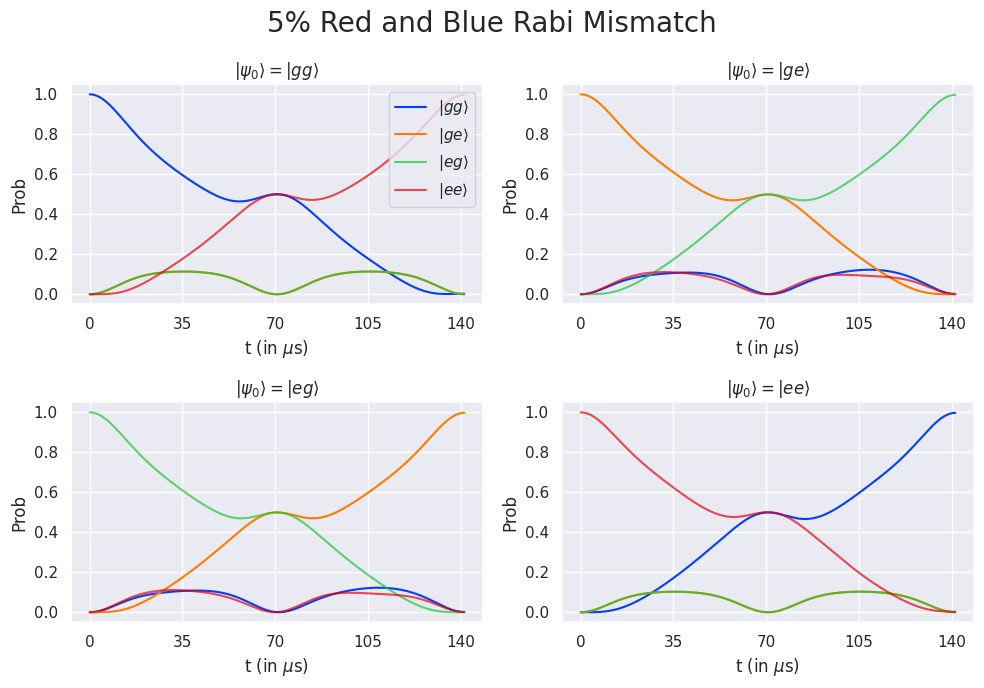

In [261]:


H_rabi=H_MS(rabi_0*.975, rabi_0*1.025    , epsilon, -epsilon)
plot_evol_basis(H_rabi, '5% Red and Blue Rabi Mismatch')

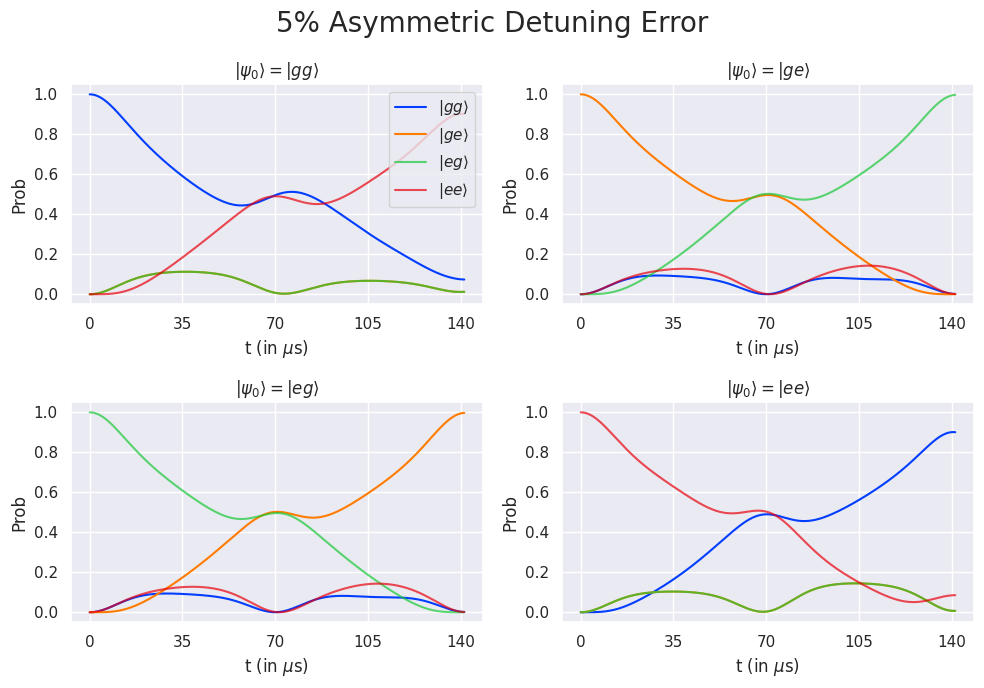

In [262]:
H_asym=H_MS(rabi_0, rabi_0, epsilon*1.05, -epsilon*.95)
plot_evol_basis(H_asym, "5% Asymmetric Detuning Error")

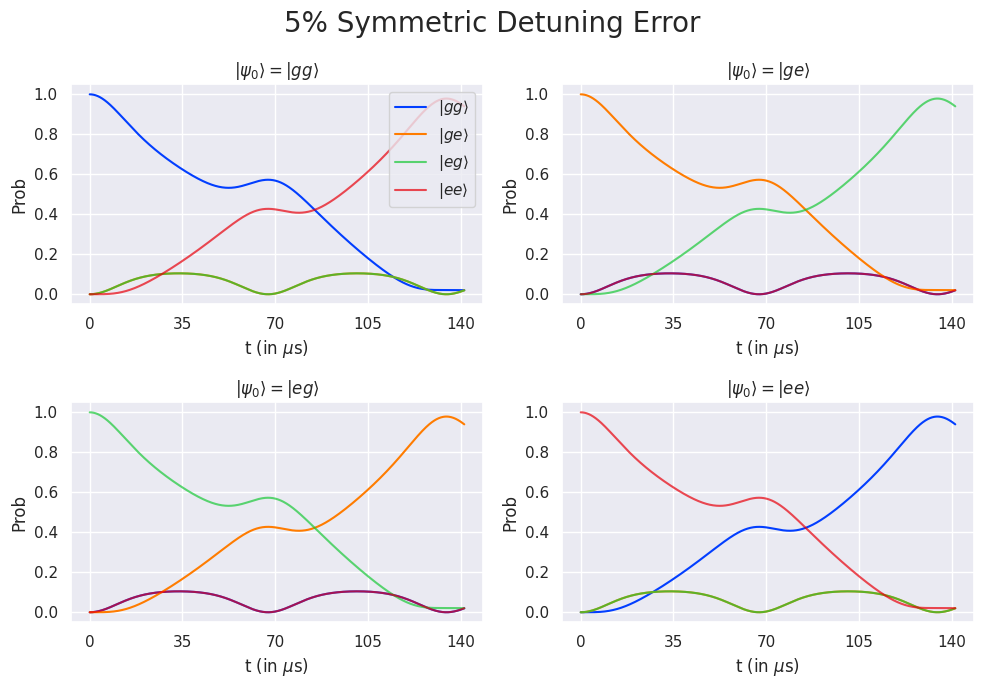

In [263]:
H_sym=H_MS(rabi_0, rabi_0, epsilon*1.05, -epsilon*1.05)
plot_evol_basis(H_sym, "5% Symmetric Detuning Error")

# Analysis
The MS gate appears to be more robust to slight drifts in the Rabi freq (proportional to laser amplitude) than other error sources discussed in this work. But, the drift in trap frequency (symmetric error) appears to be the most destructive to gate fidelity [[0]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.121.180501). The MS gate is crucial to generating maximally entangled states, and the trap frequency drift is far less robust in this regard than laser frequency or amplitude errors based on the data in this work. Regarding generating maximally entangled states, the MS gate is suprisingly very robust to minor drifts in laser amplitude and frequency. 

# The Sidequest
By Wiki's definition, the Lamb-Dicke parameter is defined as 
$$ \eta = k_z z_0$$
Where $z_0$ is the zero-point spread $z_0=\sqrt{(\frac{\hbar}{2M\omega_z})}$ (from position operator $\hat{z}=z_0(a+a^{\dagger})$) and $\omega_z$ is the frequency of the static trapping potential of the ion in direction $z$. $k_z=\frac{2\pi}{\lambda}\cos \theta$ is the $z$ projection of the laser wavevector acting on the ion. Wikipedia's definition only details a one-ion system, and does not include that $M$ includes the mass of all ions in the chain [[1]](https://iontrap.umd.edu/wp-content/uploads/2012/12/Simplified-quantum-logic-with-trapped-ions.pdf). Assuming the ions are of the same species, a trapped $2$ ion crystal would have thus $2M$ mass, scaling the Lamb-Dicke parameter by $\frac{1}{\sqrt{2}}$.